# Problem Set 1 Question 3
## Isaac Liu

In [16]:
# Packages
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Set seed for reproducibility
np.random.seed(605477)

In [18]:
# Fixed parameters
alpha = 0
beta_1 = 1

In [19]:
# Write the DGP as a function
def DGP(N, rho, beta_2):
    
    # Make sure N is an integer
    N = int(N)

    # Variance-covariance matrix
    Sigma = [[1, rho], [rho, 1]]

    # Produce joint normal x vectors, mean 0, variance-covariance Sigma, of length N
    x_1, x_2 = np.random.multivariate_normal(mean=[0,0], cov=Sigma, size=N).T

    # Standard normal error vector of size N
    e = np.random.normal(size=N)

    # Compute y using formula
    y = alpha*np.ones(N) + beta_1*x_1 + beta_2*x_2 + e

    return(y, x_1, x_2)

In [20]:
# Define a function which will accept dataframe columns and calculate model statistics
def run_simulations(N, rho, beta_2):
    
    # Storing five lists of coefficients, CIs, whether the CI includes one, number of x in the model ultimately chosen. 
    # Each of these should have length 1000, one item for each simulation.
    x_1_coeffs_chosen = []
    x_1_coeffs_unrestricted = []
    CIs_chosen = []
    CI_includes_1 = []
    num_of_x_in_addition_to_x1 = []

    # Run DGP 1000 times given the parameters and follow the decision rule
    for i in range(1000):

        y, x_1, x_2 = DGP(N, rho, beta_2)

        # Estimate the unrestricted model
        # Note that I exclude the constant/intercept, alpha = 0
        unrestricted_results = sm.OLS(y, np.vstack((x_1, x_2)).T).fit()

        # Calculate p val for x_2 for decision rule
        # There's no constant so x_1 is first item in the parameters list at index 0, x_2 is the second at index 1
        p_val_x_2_unrestricted = unrestricted_results.pvalues[1]

        # Decision rule: get the coefficient of x_1 (beta_1), unrestricted if the p-value of x_2 is low and restricted if it is not
        # Note: I think there is a typo in the explanation in the text at the bottom of page 3 and the decision rule given as (4) is correct
        # We want to keep beta_2 hat and use the unrestricted model if it is very significant and has a low p value
        # Also, the rule is stated as less than in the written out explanation in the text but it's less than or equal to in (4)
        # Don't know why the cutoff is also defined as alpha, but it's 0.05
        if p_val_x_2_unrestricted <= 0.05:

            # Append coeff and CI for x_1 from unrestricted to chosen
            x_1_coeffs_chosen.append(unrestricted_results.params[0])
            
            # Note the conf_int default is 0.05/5% level in statsmodels
            CIs_chosen.append(unrestricted_results.conf_int()[0])

            # Used both x in unrestricted
            num_of_x_in_addition_to_x1.append(1)

        else:

            # Estimate a restricted model
            restricted_results = sm.OLS(y, x_1).fit()

            # Append coeff and CI for x_1 from restricted to chosen
            x_1_coeffs_chosen.append(restricted_results.params[0])

            CIs_chosen.append(restricted_results.conf_int()[0])

            # Used only x_1
            num_of_x_in_addition_to_x1.append(0)

        # Check if CI includes 1
        CI_includes_1.append(CIs_chosen[i][0] <= 1 <= CIs_chosen[i][1])

        # Append unrestricted model coeff to the list
        x_1_coeffs_unrestricted.append(unrestricted_results.params[0])

    return(x_1_coeffs_chosen, x_1_coeffs_unrestricted, CIs_chosen, CI_includes_1, num_of_x_in_addition_to_x1)

In [21]:
# Make a dataframe of Cartesian products of parameters
# I'm looping through all of the combinations, I guess we could skip all the rhos and beta_2s for N other than 1000 as given in the footnote, but it's easier, interesting, and not computationally intensive to just do them.
Ns = [50, 100, 200, 1000]
rhos = [0.1, 0.5, 0.9]
beta_2s = [0.01, 0.05, 0.1, 0.2, 1]

index = pd.MultiIndex.from_product([Ns, rhos, beta_2s], names = ["N", "rho", "beta_2"])

scenarios = pd.DataFrame(index = index).reset_index()

In [22]:
# Apply the DGP function scenario parameters to get the results
scenarios['results'] = scenarios.progress_apply(lambda x: run_simulations(x.N, x.rho, x.beta_2), axis = 1)

100%|██████████| 60/60 [01:03<00:00,  1.06s/it]


In [23]:
# Create a new dataframe for plotting. We're trying to make the dataframe as long as possible.
# Start with the parameter values
scenarios_for_plot = scenarios[['N', 'rho', 'beta_2']]
# Unpack the results column of scenarios. It is a list of lists. Explode will put each list in a new row (meaning there will be 5 times as many rows).
# Then, for the chosen model column I keep the coefficients from every fifth row (index 0, 5 ...), for the unrestricted model I do the same shifted up by one (index 1, 6 ...).
scenarios_for_plot['chosen'] = scenarios.explode('results').reset_index().iloc[::5].reset_index()['results']
scenarios_for_plot['unrestricted'] = scenarios.explode('results').reset_index().iloc[1::5].reset_index()['results']
# Reshape the chosen and unrestricted models into one column to hold coefficients.
scenarios_for_plot = pd.melt(scenarios_for_plot, id_vars=['N', 'rho', 'beta_2'], value_vars=['chosen', 'unrestricted'], var_name='model', value_name='coeff')
# Further unpack the lists of 1000 coefficients to get one coeff per row.
scenarios_for_plot = scenarios_for_plot.explode('coeff')
scenarios_for_plot

,N,rho,beta_2,model,coeff
0,50,0.1,0.01,chosen,1.098697
0,50,0.1,0.01,chosen,0.872003
0,50,0.1,0.01,chosen,0.685318
0,50,0.1,0.01,chosen,1.214943
0,50,0.1,0.01,chosen,1.053251
...,...,...,...,...,...
119,1000,0.9,1.00,unrestricted,1.087404
119,1000,0.9,1.00,unrestricted,1.105675
119,1000,0.9,1.00,unrestricted,1.00847
119,1000,0.9,1.00,unrestricted,0.988327


In [24]:
# Function to make the seaborn faceted panels for a given N value
def make_grid(N):
    scenarios_for_plot_grid = scenarios_for_plot[scenarios_for_plot['N'] == N]
    grid = sns.FacetGrid(scenarios_for_plot_grid, col='rho', row='beta_2')
    grid.map_dataframe(sns.histplot, x='coeff', hue='model')
    grid.fig.subplots_adjust(top=0.95)
    grid.fig.suptitle('Beta_1 for N = ' + str(N), size = 16, y = 0.99)
    grid.fig.legend(labels = ['Unrestricted', 'Chosen'], loc = 'upper right', ncol=2)

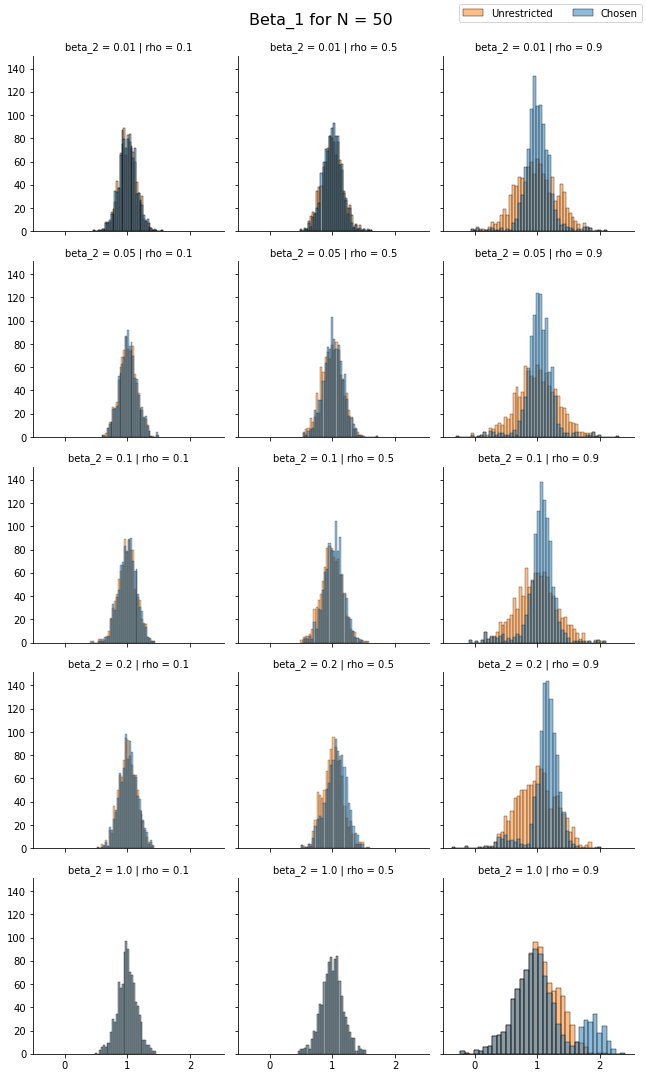

In [25]:
make_grid(50)

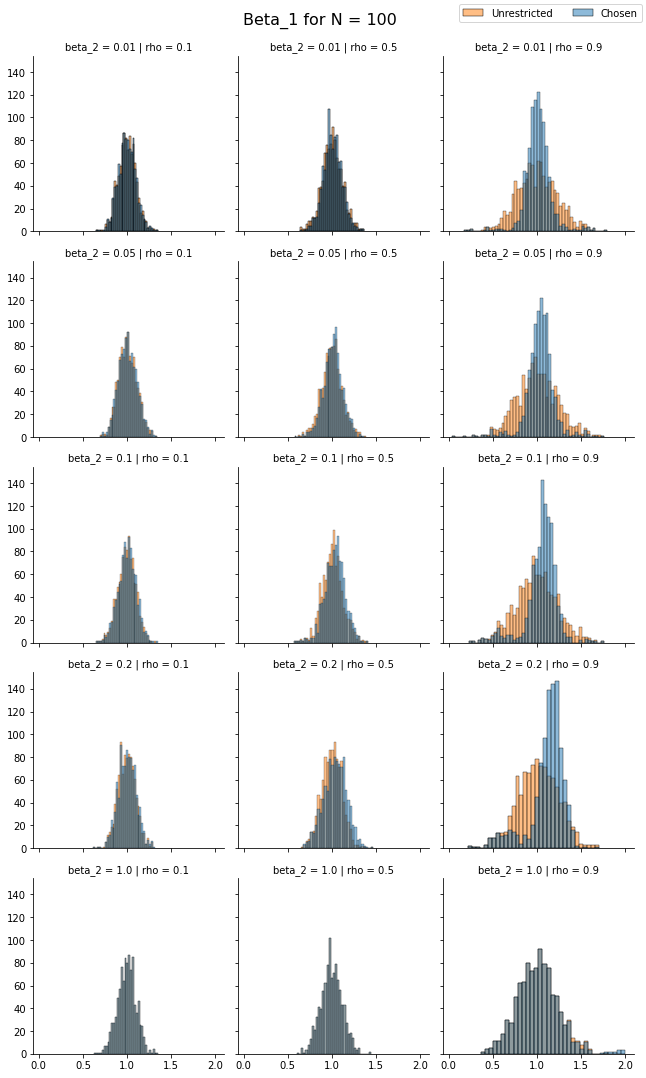

In [26]:
make_grid(100)

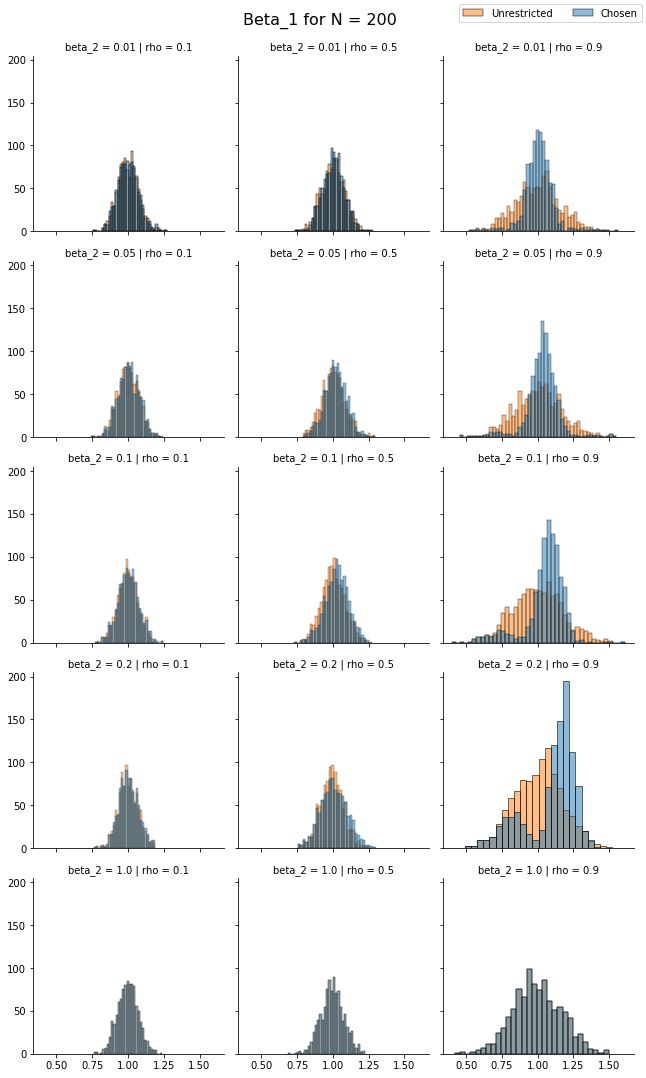

In [27]:
make_grid(200)

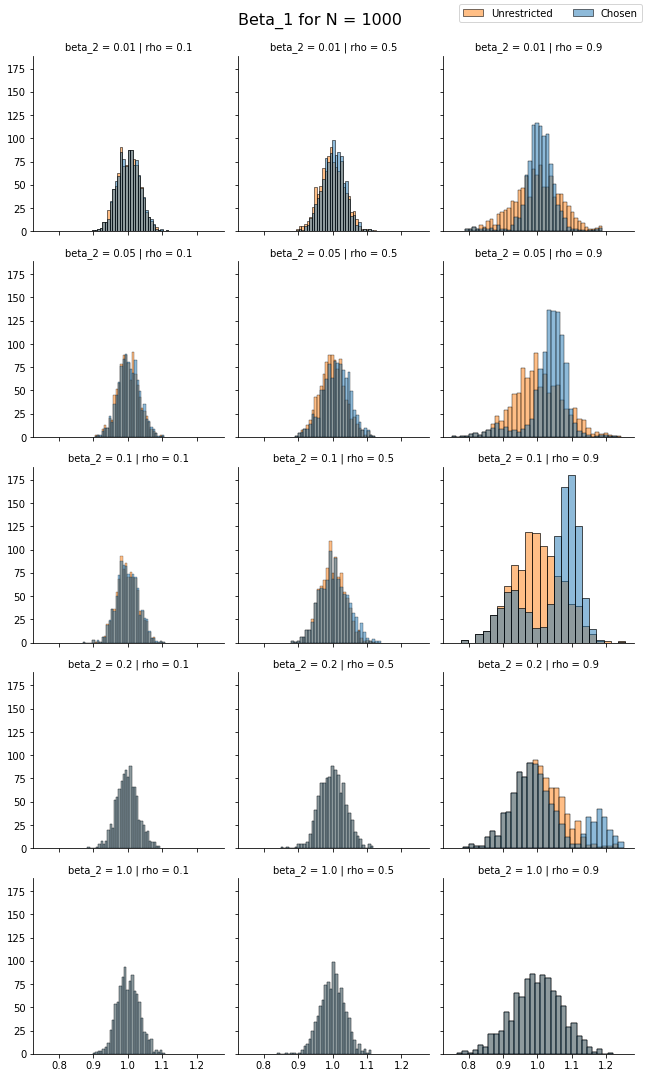

In [28]:
make_grid(1000)

In [29]:
# Share of confidence intervals containing one
def compute_CIs_containing_one(results):
    return(sum(results[3]) / len(results[3]))

In [30]:
# Table with the percentage of cases where the CI had a true value of beta_1 = 1
scenarios_CI_cases = scenarios
scenarios_CI_cases['Percent_w_CI_including_1'] = scenarios_CI_cases.apply(lambda x: compute_CIs_containing_one(x.results), axis = 1) * 100

scenarios_CI_cases[['N','rho','beta_2','Percent_w_CI_including_1']]

,N,rho,beta_2,Percent_w_CI_including_1
0,50,0.1,0.01,94.8
1,50,0.1,0.05,95.6
2,50,0.1,0.10,94.8
3,50,0.1,0.20,94.5
4,50,0.1,1.00,93.4
5,50,0.5,0.01,94.6
6,50,0.5,0.05,92.9
7,50,0.5,0.10,94.1
8,50,0.5,0.20,90.4
9,50,0.5,1.00,94.0


#### Answer the following two questions:

1. What is the distribution of $\beta|X$ (should be $\beta_1$) when estimating the unrestricted model?

The unrestricted model is generally normally distributed and centered around the true parameter value of one. This is what one would usually expect with multivariate OLS when including all of the parameters; we achieve unbiased estimates. Higher values of $\rho$ do induce larger variance for the unrestricted $\beta_1$ due to multicollinearity, however.

2. How does the distribution of $\hat{\beta}$ (should be $\beta_1$) change as you change the parameters?

As we increase $N$, and we hold the other parameters fixed, the variance of the distributions falls. This is expected and can be seen by examining the shrinking scale of the x axis in the histograms. The unrestricted model coefficient is generally unbiased and always centered around 1. However, as $N$ increases the chosen model coefficients become bimodal and potentially biased.

As we increase $\rho$ and hold the other parameters fixed the variance of $\hat{\beta}$ clearly increases. We are introducing multicolinearity as $x_1$ and $x_2$ become correlated, so the precision of $\beta_1$ will decrease. Furthermore in the case of high $\rho$ and moderate values of $\beta_2$, we also see a divergence between the the chosen models (restricted and unrestricted), particularly with large $N$ (or at least, the difference is noticable with large $N$ since the estimates are more precise), meaning that the overall chosen model distribution is bimodal.

As we vary $\beta_2$ and hold the other parameters fixed, we see major changes in the case where $\rho$ is high. If $\beta_2$ is very close to zero, it does not lead to bias (note that in the formula for omitted variable bias, bias is severe only if the omitted item strongly affects the outcome variable). Furthermore, given the decision rule, it is very likely we will choose the restricted model nearly all of the time, so the distribution is not bimodal. When $\beta_2$ approaches one, for sufficiently large $N$, we will always choose the unrestricted model, so again there is no bias and not a bimodal distribution. It is only for intermediate values of $\beta_2$ that we see a divergence and bimodal distribution of the chosen values.

What does your result imply for inference in a finite sample setting? Does relying on the asymptotic distribution make sense?

Usually, we would expect the estimates to be normally distributed, unbiased, and consistent asymptotically, and conduct inference based on this. However, it is pretty clear that in this case, going up towards $N=1000$ does not lead to this expected behavior because of the decision rule. The distribution is still bimodal. The implications of this for inference are very clear when examining the table of percentages of CIs which include the true value, and in fact it appears to be the case that the CI misses the true value even more often with high $N$ (and high $\rho$ and intermediate $\beta_2$), likely due to increased precision of the non-centered bimodal distribution. $N$ mostly improves the quality of the unrestricted estimates only.

What does this simulation imply for the LASSO?

Unfortunately under the LASSO we will, to some degree, be choosing the model, which could lead to the nasty results of this simulation. Fortunately, the LASSO will allow for somewhat more "soft" thresholding, where values are shrunken rather than set to zero under certain conditions (like in this simulation, where $x_2$ is excluded). We should probably be concerned about using LASSO when there might be a high degree of correlation between regressors.

What does this result imply for cases in which the researcher looks the data before deciding on which model to estimate?

This simulation appears to suggest that looking at the data and using a decision rule such as the one used is a poor idea. With a large degree of correlation between regressors with intermediate true values, selecting a model can lead to a large amount of bias. Large $N$s do not improve quality and may even further lead to distortion given a decision rule based on p-values. The use of a rule such as the one examined in this exercise is not robust because it can greatly affect the parameter values.